In [1]:
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<IPython.core.display.Javascript object>

# Cat Boost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import os
import random

from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import eli5
from eli5.sklearn import PermutationImportance

import warnings

warnings.filterwarnings(action="ignore")  # 경고 출력 무시

<IPython.core.display.Javascript object>

## 1. 데이터로딩

In [196]:
data_dir = "/opt/ml/input/data/"  # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, "all_feature_data.csv")  # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path)


# 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
df.sort_values(by=["userID", "Timestamp"], inplace=True)

<IPython.core.display.Javascript object>

In [202]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,tagLV,tagMean,eloTest,...,bigClassElapsedTimeAvg,recCount,year,tagClass,GradeAcc,Grade_o,GradeCount,GradeElp,GradeMElp,RepeatedTime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1.0,0.957333,0.962544,...,31,0,2020,108,0.0,0.0,0,0.0,0.00,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,1.0,0.917067,0.962544,...,31,1,2020,108,1.0,1.0,1,3.0,3.00,1.386294
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,1.0,0.917067,0.962544,...,31,2,2020,108,1.0,2.0,2,11.0,5.50,2.197225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,1.0,0.917067,0.962544,...,31,3,2020,108,1.0,3.0,3,18.0,6.00,2.079442
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,1.0,0.917067,0.962544,...,31,4,2020,108,1.0,4.0,4,25.0,6.25,2.079442


<IPython.core.display.Javascript object>

## 2. Train/Test 데이터 셋 분리 (option1, option2에서 하나만 실행)

### Option 1
- train 데이터에서 train, valid set을 나눔

In [203]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)


def option1_train_test_split(df, ratio=0.8, split=True):

    df = df[df.dataset == 1]

    users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
    random.shuffle(users)

    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids = []

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df["userID"].isin(user_ids)]
    test = df[df["userID"].isin(user_ids) == False]

    # test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test["userID"] != test["userID"].shift(-1)]
    return train, test

<IPython.core.display.Javascript object>

### Option 2
- train 데이터를 모두 훈련에 사용
- valid를 test셋의 마지막 두번째 데이터로 진행

In [204]:
def option2_train_test_split(df):
    # use train dataset only for train
    train = df[df.dataset == 1]

    # use test dataset only for valid
    test = df[(df.dataset == 2)]  # & (df.answerCode != -1)]  # -1 인 answerCode 제외

    # test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test["userID"] != test["userID"].shift(-1)]

    return train, test

<IPython.core.display.Javascript object>

In [205]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'dataset', 'tagLV', 'tagMean', 'eloTest', 'cumCorrect',
       'assessMean', 'accuracy', 'tagSum', 'elo', 'bigClassAccCate',
       'userLVbyTest', 'eloTag', 'assessSum', 'bigClass', 'KTAccuracyCate',
       'day', 'month', 'KnowledgeTagAcc', 'userLVbyTestAVG', 'testStd',
       'elapsedTime', 'testSum', 'tagStd', 'assessStd', 'elapsedTimeClass',
       'hour', 'testMean', 'tagCluster', 'totalAnswer', 'bigClassAcc',
       'recAccuracy', 'cumAccuracy', 'testLV', 'seenCount', 'userLVbyTag',
       'userLVbyTagAVG', 'tagCount', 'weekNum', 'bigClassCount', 'wday',
       'bigClassElapsedTimeAvg', 'recCount', 'year', 'tagClass', 'GradeAcc',
       'Grade_o', 'GradeCount', 'GradeElp', 'GradeMElp', 'RepeatedTime'],
      dtype='object')

<IPython.core.display.Javascript object>

## 3. Feature Engineering

In [206]:
def feature_engineering(df, option="option1"):

    # 카테고리형 feature
    categories = [
        "assessmentItemID",
        "testId",
        "KnowledgeTag",
        "bigClassAccCate",
        "bigClass",
        "KTAccuracyCate",
        "day",
        "month",
        "year",
        "wday",
        "weekNum",
        "hour",
        "elapsedTimeClass",
        "tagCluster",
        "testLV",
        "userLVbyTest",
        "userLVbyTestAVG",
        "tagLV",
        "userLVbyTag",
        "userLVbyTagAVG",
        "tagClass",
    ]  # TODO : category feature를 변환시켜줘야함

    le = preprocessing.LabelEncoder()
    # df["elo"] = df["elo"].transform(lambda x: int(x * 100000000))

    for category in categories:
        if df[category].dtypes != "int":  # float, str type -> int로 전환
            df[category] = le.fit_transform(df[category])
        df[category] = df[category].astype("category")

    return df

<IPython.core.display.Javascript object>

In [207]:
df = feature_engineering(df)

<IPython.core.display.Javascript object>

In [208]:
train, valid = option1_train_test_split(df)
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,dataset,tagLV,tagMean,eloTest,...,bigClassElapsedTimeAvg,recCount,year,tagClass,GradeAcc,Grade_o,GradeCount,GradeElp,GradeMElp,RepeatedTime
0,0,5354,975,1,2020-03-24 00:17:11,7224,1,0,0.957333,0.962544,...,31,0,2020,108,0.0,0.0,0,0.0,0.00,0.000000
1,0,5355,975,1,2020-03-24 00:17:14,7225,1,0,0.917067,0.962544,...,31,1,2020,108,1.0,1.0,1,3.0,3.00,1.386294
2,0,5356,975,1,2020-03-24 00:17:22,7225,1,0,0.917067,0.962544,...,31,2,2020,108,1.0,2.0,2,11.0,5.50,2.197225
3,0,5357,975,1,2020-03-24 00:17:29,7225,1,0,0.917067,0.962544,...,31,3,2020,108,1.0,3.0,3,18.0,6.00,2.079442
4,0,5358,975,1,2020-03-24 00:17:36,7225,1,0,0.917067,0.962544,...,31,4,2020,108,1.0,4.0,4,25.0,6.25,2.079442


<IPython.core.display.Javascript object>

## 4. 데이터셋 정의

In [209]:
# X, y 값 분리
y_train = train["answerCode"]
train = train.drop(["answerCode"], axis=1)

y_valid = valid["answerCode"]
valid = valid.drop(["answerCode"], axis=1)

<IPython.core.display.Javascript object>

In [210]:
# TODO :사용할 Feature 설정
FEATS = [
    "assessmentItemID",
    # "testId",
    # "KnowledgeTag",
    "accuracy",
    # "user_total_answer",
    "testMean",
    # "testSum",
    "testStd",
    "tagMean",
    # "tagSum",
    "tagStd",
    # "assessSum",
    "assessMean",
    "assessStd",
    # -- 여기서부터 Custom Feature Engineering
    # "bigClass",
    "bigClassAcc",
    "bigClassElapsedTimeAvg",
    "bigClassAccCate",
    # "recAccuracy",
    "cumAccuracy",
    # "cumCorrect",
    # "day",
    "month",
    # "year",
    # "wday",
    # "weekNum",
    # "hour",
    "elapsedTime",
    "elapsedTimeClass",
    # "KnowledgeTagAcc",
    # "KTAccuracyCate",
    # "seenCount",
    # "tagCluster",
    # "tagCount",
    # "testLV",
    # "userLVbyTest",
    # "userLVbyTestAVG",
    # "tagLV",
    # "userLVbyTag",
    # "userLVbyTagAVG",
    # "bigClassCount",
    "recCount",
    "elo",
    "eloTest",
    "eloTag",
    # "tagClass",
    # "GradeAcc",
    # "Grade_o",
    # "GradeCount",
    # "GradeElp",
    # "GradeMElp",
    # "RepeatedTime",
]

<IPython.core.display.Javascript object>

In [223]:
FEATS = [
    "GradeAcc",
    "assessMean",
    "RepeatedTime",
    "recCount",
    "bigClassElapsedTimeAvg",
    "elo",
    "accuracy",
    # "Grade_o",
    # "GradeCount",
    "GradeElp",
    "GradeMElp",
]

<IPython.core.display.Javascript object>

In [224]:
print(FEATS)

['GradeAcc', 'assessMean', 'RepeatedTime', 'recCount', 'bigClassElapsedTimeAvg', 'elo', 'accuracy', 'GradeElp', 'GradeMElp']


<IPython.core.display.Javascript object>

In [225]:
cat_cols = train[FEATS].columns[train[FEATS].dtypes == "category"].to_list()
num_cols = train[FEATS].columns[train[FEATS].dtypes != "category"].to_list()

print(f"cat_cols: {cat_cols}")
print(f"num_cols: {num_cols}")

cat_cols: []
num_cols: ['GradeAcc', 'assessMean', 'RepeatedTime', 'recCount', 'bigClassElapsedTimeAvg', 'elo', 'accuracy', 'GradeElp', 'GradeMElp']


<IPython.core.display.Javascript object>

## 5. 훈련 및 검증

In [226]:
train_pool = Pool(train[FEATS], y_train, cat_features=cat_cols)
eval_pool = Pool(valid[FEATS], y_valid, cat_features=cat_cols)

<IPython.core.display.Javascript object>

In [227]:
params = {
    "iterations": 1500,
    "learning_rate": 0.1,  # 0.1
    "eval_metric": "AUC",
    "random_seed": 42,
    "logging_level": "Silent",
    "early_stopping_rounds": 50,
    "use_best_model": True,
    # "task_type": "GPU",
    "bagging_temperature": 1,
    "cat_features": cat_cols,
}

model = CatBoostClassifier(
    **params,
)

model.fit(
    train[FEATS],
    y_train,
    eval_set=[(valid[FEATS], y_valid)],
    # cat_features=cat_cols,
    plot=True,
    # logging_level="Verbose",  # you can uncomment this for text output
)

preds = model.predict_proba(valid[FEATS])[:, 1]
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

VALID AUC : 0.8411523645010445 ACC : 0.760752688172043



<IPython.core.display.Javascript object>

### Permutation Importance 출력

In [ ]:
perm = PermutationImportance(
    model,
    scoring="roc_auc",
    n_iter=1,
    random_state=42,
    cv=None,
    refit=False,
).fit(valid[FEATS], y_valid)
eli5.show_weights(perm, top=len(FEATS), feature_names=FEATS)

### Feature Importance 출력

Text(0.5, 1.0, 'Feature Importance')

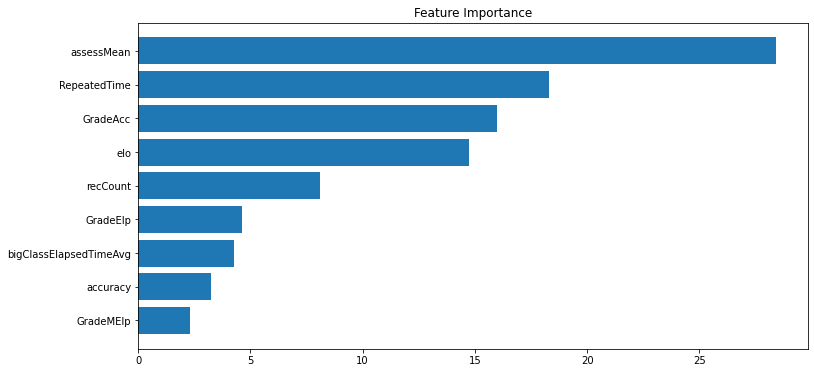

<IPython.core.display.Javascript object>

In [228]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(FEATS)[sorted_idx])
plt.title("Feature Importance")

### CV 평가

In [ ]:
model.get_params()

In [49]:
cv_params = model.get_params()
cv_params.update(
    {
        "loss_function": metrics.Logloss(),
    }
)

# train_df = df[df["dataset"] == 1]
# df_cv = feature_engineering(train_df, option="total")
# X_cv, y_cv = df_cv.drop(["answerCode"], axis=1), df_cv["answerCode"]

cv_data = cv(
    params=cv_params,
    pool=Pool(train[FEATS], y_train, cat_features=cat_cols),  ## fit  method 구문의 역할을 한다.
    fold_count=3,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<IPython.core.display.Javascript object>

In [29]:
## 요약된 결과보기
cv_data.head()

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.787238,0.000207,0.654594,0.000093,0.655621,0.000051
1,1,0.792841,0.000195,0.624712,0.000151,0.626501,0.000065
2,2,0.798221,0.000662,0.601826,0.000080,0.603777,0.000118
3,3,0.800571,0.001644,0.582347,0.000058,0.584902,0.000219
4,4,0.802364,0.000673,0.567004,0.000137,0.569949,0.000296


<IPython.core.display.Javascript object>

In [30]:
best_value = np.max(cv_data["test-AUC-mean"])
best_iter = np.argmax(cv_data["test-AUC-mean"])

print(
    "Best validation AUC score, not stratified: {:.4f}±{:.4f} on step {}".format(
        best_value, cv_data["test-AUC-std"][best_iter], best_iter
    )
)

Best validation AUC score, not stratified: 0.8484±0.0007 on step 199


<IPython.core.display.Javascript object>

## 6. 하이퍼파라미터 튜닝

In [34]:
import hyperopt

<IPython.core.display.Javascript object>

In [43]:
def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params["l2_leaf_reg"]),
        learning_rate=params["learning_rate"],
        iterations=200,
        eval_metric="AUC",
        random_seed=42,
        verbose=False,
        loss_function=metrics.Logloss(),
    )

    train_df = df[df["dataset"] == 1]
    df_cv = feature_engineering(train_df, option="total")
    X_cv, y_cv = df_cv.drop(["answerCode"], axis=1), df_cv["answerCode"]

    cv_data = cv(
        Pool(X_cv[FEATS], y_cv, cat_features=FEATS),
        model.get_params(),
        logging_level="Silent",
    )
    best_auc = np.max(cv_data["test-AUC-mean"])

    return 1 - best_auc  # as hyperopt minimises

<IPython.core.display.Javascript object>

In [41]:
np.random.default_rng(123)

Generator(PCG64) at 0x7F0FA65B29A0

<IPython.core.display.Javascript object>

In [44]:
from numpy.random import RandomState

params_space = {
    "l2_leaf_reg": hyperopt.hp.qloguniform("l2_leaf_reg", 0, 2, 1),
    "learning_rate": hyperopt.hp.uniform("learning_rate", 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(123),
)

print(best)

100%|██████████| 50/50 [10:34:31<00:00, 761.43s/trial, best loss: 0.14521130101944157] 
{'l2_leaf_reg': 1.0, 'learning_rate': 0.3555652573872889}


<IPython.core.display.Javascript object>

best hyperparameter: {'l2_leaf_reg': 1.0, 'learning_rate': 0.3555652573872889}

In [46]:
print(best)

{'l2_leaf_reg': 1.0, 'learning_rate': 0.3555652573872889}


<IPython.core.display.Javascript object>

In [ ]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best["l2_leaf_reg"]),
    learning_rate=best["learning_rate"],
    iterations=200,
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
    loss_function=metrics.Logloss(),
)

train_df = df[df["dataset"] == 1]
df_cv = feature_engineering(train_df, option="total")
X_cv, y_cv = df_cv.drop(["answerCode"], axis=1), df_cv["answerCode"]

cv_data = cv(Pool(X_cv[FEATS], y_cv, cat_features=FEATS), model.get_params())

In [ ]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

## 7. Inference

### 7-1. Inferece by test [-2] (test dataset 뒤에서 두번째 값으로 성능 측정)

In [26]:
# use test dataset only for valid
test = df[(df.dataset == 2) & (df.answerCode != -1)]  # -1 인 answerCode 제외

# test데이터셋은 각 유저의 마지막 interaction만 추출
test = test[test["userID"] != test["userID"].shift(-1)]

y_test = test["answerCode"]
test = test.drop(["answerCode"], axis=1)

preds = model.predict_proba(test[FEATS])[:, 1]
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f"VALID AUC : {auc} ACC : {acc}")

VALID AUC : 0.8232006612876088 ACC : 0.7580645161290323


<IPython.core.display.Javascript object>

### 7-2. 종테기 결과

In [229]:
test_df = df[df.dataset == 2]

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df["userID"] != test_df["userID"].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(["answerCode"], axis=1)

# MAKE PREDICTION
total_preds = model.predict_proba(test_df[FEATS])[:, 1]

<IPython.core.display.Javascript object>

### 7-3. 제출

In [231]:
# SAVE OUTPUT
output_dir = "output/"
write_path = os.path.join(output_dir, "CatBoost_submission_(8411).csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : output/CatBoost_submission_(8411).csv


<IPython.core.display.Javascript object>